In [1]:
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Lambda, Dense
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
data = """
Deep learning is a subset of machine learning that uses artificial neural networks. 
Neural networks are inspired by the human brain. 
They consist of layers of interconnected nodes or neurons that process data. 
Deep learning algorithms can automatically extract features from raw data. 
Applications include image recognition, natural language processing, and autonomous driving. 
As data grows, deep learning models improve performance by learning from examples.
"""

In [3]:
sentences = data.split('.')
clean_sent = []

for sentence in sentences:
    sentence = sentence.strip()
    if sentence == "":
        continue
    sentence = re.sub('[^A-Za-z0-9 ]+', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    clean_sent.append(sentence)

print("Cleaned Sentences:", clean_sent[:3])

Cleaned Sentences: ['deep learning is a subset of machine learning that uses artificial neural networks', 'neural networks are inspired by the human brain', 'they consist of layers of interconnected nodes or neurons that process data']


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_sent)
sequences = tokenizer.texts_to_sequences(clean_sent)

word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_to_index.items()}
vocab_size = len(word_to_index) + 1

print("\n Vocabulary Size:", vocab_size)
print("Sample word-index mapping:", list(word_to_index.items())[:10])


 Vocabulary Size: 51
Sample word-index mapping: [('learning', 1), ('deep', 2), ('of', 3), ('data', 4), ('that', 5), ('neural', 6), ('networks', 7), ('by', 8), ('from', 9), ('is', 10)]


In [7]:
context_size = 2
contexts, targets = [], []

for seq in sequences:
    if len(seq) < 2 * context_size + 1:
        continue
    for i in range(context_size, len(seq) - context_size):
        context = [seq[i - 2], seq[i - 1], seq[i + 1], seq[i + 2]]
        target = seq[i]
        contexts.append(context)
        targets.append(target)

X = np.array(contexts)
Y = np.array(targets)

for i in range(3):
    c_words = [index_to_word[idx] for idx in X[i]]
    t_word = index_to_word[Y[i]]
    print(f"Context: {c_words} ➜ Target: {t_word}")

Context: ['deep', 'learning', 'a', 'subset'] ➜ Target: is
Context: ['learning', 'is', 'subset', 'of'] ➜ Target: a
Context: ['is', 'a', 'of', 'machine'] ➜ Target: subset


In [8]:
embedding_dim = 50  

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Lambda(lambda x: tf.reduce_mean(x, axis=1)),  
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=150, batch_size=8, verbose=0)

model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 4, 50)               │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 51)                  │           6,579 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,973 (183.49 KB)

 Trainable params: 15,657 (61.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,316 (122.33 KB)

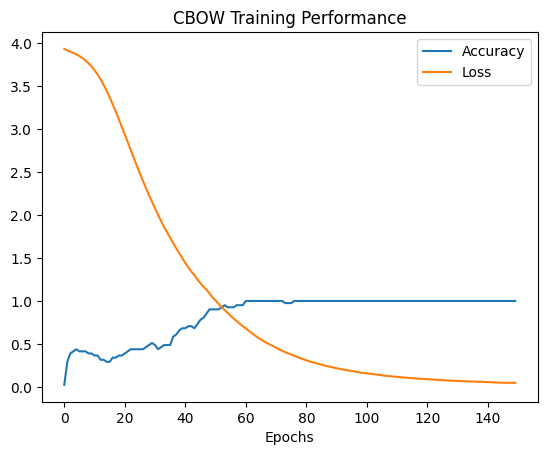

In [9]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title("CBOW Training Performance")
plt.show()

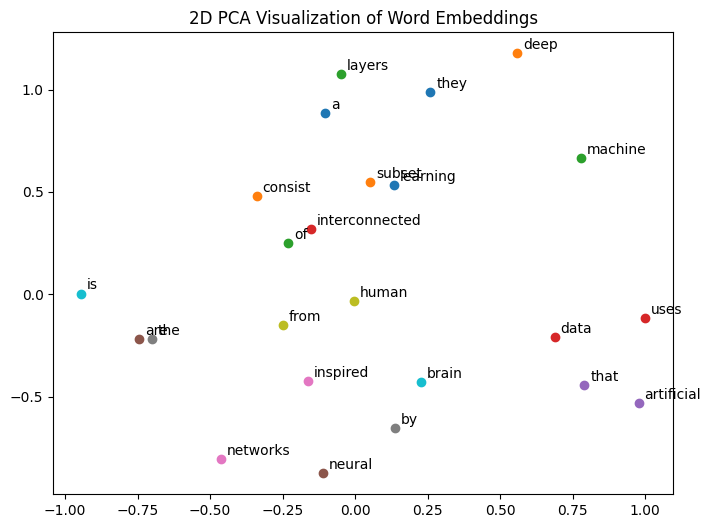

In [10]:
embeddings = model.get_weights()[0]
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for word, idx in word_to_index.items():
    if idx < 25:  # show top 25 words
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1])
        plt.text(reduced_embeddings[idx, 0]+0.02, reduced_embeddings[idx, 1]+0.02, word)
plt.title("2D PCA Visualization of Word Embeddings")
plt.show()

In [12]:
def predict_next_word(context_words):
    try:
        context_ids = [word_to_index[w] for w in context_words]
        if len(context_ids) != 4:
            print(" Please provide exactly 4 context words (2 before + 2 after).")
            return
        preds = model.predict(np.array([context_ids]), verbose=0)
        predicted_id = np.argmax(preds)
        predicted_word = index_to_word.get(predicted_id, 'Unknown')
        print(f"Context: {context_words} ➜ Predicted word: {predicted_word}")
    except KeyError as e:
        print("Word not in vocabulary:", e)

In [13]:
predict_next_word(['deep', 'learning', 'uses', 'artificial'])
predict_next_word(['networks', 'are', 'by', 'human'])
predict_next_word(['deep', 'learning', 'models', 'performance'])
predict_next_word(['natural', 'language', 'and', 'autonomous'])

Context: ['deep', 'learning', 'uses', 'artificial'] ➜ Predicted word: that
Context: ['networks', 'are', 'by', 'human'] ➜ Predicted word: inspired
Context: ['deep', 'learning', 'models', 'performance'] ➜ Predicted word: models
Context: ['natural', 'language', 'and', 'autonomous'] ➜ Predicted word: processing
